# NN5: Testowanie różnych funkcji aktywacji
Adrianna Grudzień

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [51]:
class Layer:
    def __init__(self, shape, activation='sigmoid'):
        self.shape = shape
        self.activation = activation
        self._initialize_weights()

    def _initialize_weights(self, min_val=-0.5, max_val=0.5):
        self.weights = np.random.uniform(min_val, max_val, size=self.shape)
        self.biases = np.random.uniform(min_val, max_val, size=self.shape[1])

    def calculate(self, x):
        return np.matmul(x, self.weights) + self.biases

    def activate(self, x):
        if self.activation == 'sigmoid':
            return Layer.sigmoid(x)
        if self.activation == 'tanh':
            return Layer.tanh(x)
        if self.activation == 'ReLU':
            return Layer.ReLU(x)
        if self.activation == 'linear':
            return x

    def update(self, delta_weights, delta_biases):
        self.weights += np.array(np.reshape(delta_weights, self.shape))
        self.biases += np.array(np.reshape(delta_biases, self.shape[1]))

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def tanh(x):
        return (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))
    @staticmethod
    def ReLU(x):
        out = np.where(x>0, x, 0)
#         out = np.zeros(shape=len(x))
#         for i in range(len(x)):
#             if x[i] > 0:
#                 out[i] = x[i]
        return out

class NN:
    def __init__(self, input_shape, output_size, layers_num=1, neurons_num=[5], activations=['linear']):
        self.input_shape = input_shape
        # self.output_size = output_size
        self.layers_num = layers_num
        self.neurons_num = neurons_num
        self.activations = activations
        self._build()

    def visualise_weights(self):
        for i in range(self.layers_num):
            plt.subplot(self.layers_num, 1, i+1)
            plt.scatter(np.arange(self.neurons_num[i]), self.layers[i].weights)
            
        plt.show()

    @staticmethod
    def sigmoid_derivative(x):
        return np.exp(-x) / np.square((1 + np.exp(-x)))
    @staticmethod
    def tanh_derivative(x):
        return 4*np.exp(2*x) / np.square((np.exp(2*x)+1))
    @staticmethod
    def ReLU_derivative(x):
        out = np.where(x<=0, 0, 1)
#         out = np.ones(x.shape)
#         for i in range(len(x)):
#             if i<=0:
#                 out[i] = 0
        return out

    @staticmethod
    def mse(y_true, y_pred):
         return np.mean(np.square(y_true - y_pred))

    def calculate_errors(self, y_true, y_pred):
        errors = []
        for i in range(self.layers_num - 1, -1, -1):
            layer = self.layers[i]
            if layer.activation == 'linear':
                derivative = np.ones(shape=(layer.shape[-1], 1))
            if layer.activation == 'sigmoid':
                derivative = NN.sigmoid_derivative(self.recent_calculations[i + 1].reshape(layer.shape[-1], 1))
            if layer.activation == 'tanh':
                derivative = NN.tanh_derivative(self.recent_calculations[i + 1].reshape(layer.shape[-1], 1))
            if layer.activation == 'ReLU':
                derivative = NN.ReLU_derivative(self.recent_calculations[i + 1].reshape(layer.shape[-1], 1))
            if i == self.layers_num - 1:
                errors.append(np.multiply((y_pred - y_true), derivative))
            else:
                errors.append(np.multiply(derivative, np.dot(self.layers[i + 1].weights, errors[-1])))
        errors.reverse()
        return errors
        
    def backpropagate(self, y_pred, y_true, x):
        delta_weights = []
        delta_biases = []
        
        errors = self.calculate_errors(y_true, y_pred) 
        for i in range(self.layers_num - 1, 0, -1):     
            a = self.layers[i - 1].activate(self.recent_calculations[i].reshape(self.layers[i - 1].shape[-1], 1))       
            delta_weights.insert(0, -self.learning_rate * np.outer(a, errors[i]) / self.batch_size)
            # print(f'Deltas: {delta_weights[0]}')
            delta_biases.insert(0, -self.learning_rate * errors[i] / self.batch_size)
        delta_weights.insert(0, -self.learning_rate * np.outer(x, errors[0]) / self.batch_size)
        # print(f'Deltas: {delta_weights[0]}')
        delta_biases.insert(0, -self.learning_rate * errors[0] / self.batch_size)
        
        return delta_weights, delta_biases
        
    def sum_deltas(self, delta_weights, delta_biases):
        for i in range(self.layers_num):
            self.delta_weights[i] += np.array(delta_weights[i])
            self.delta_biases[i] += np.array(delta_biases[i])

    def _build(self):
        self.layers = []

        layer = Layer(shape=(self.input_shape[1], self.neurons_num[0]), activation=self.activations[0])
        self.layers.append(layer)

        for i in range(1, self.layers_num):
            layer = Layer(shape=(self.layers[i - 1].shape[1], self.neurons_num[i]), activation=self.activations[i])
            self.layers.append(layer)

        # layer = Layer(shape=(self.layers[-1].shape[1], self.output_size), activation=self.activations[-1])
        # self.layers.append(layer)

    @staticmethod
    def convert_to_numpy_array(x_train, y_train, x_test, y_test):
        if x_test is None or y_test is None:
            return np.array(x_train), np.array(y_train), None, None
        else:
            return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    def update_layers(self):
        # print(self.delta_weights)
        for i in range(self.layers_num):  
            self.layers[i].update(self.delta_weights[i], self.delta_biases[i])

    def print_results(self, epoch):
        print(f'Epoch number {epoch}/{self.n_epochs}')
        print(f'MSE on training set: {NN.mse(self.y_train, self.predict(self.x_train))}', end=' ')
        if self.x_test is not None:
            print(f'     , MSE on test set: {NN.mse(self.y_test, self.predict(self.x_test))}')

    def fit(self, x_train, y_train, batch_size, n_epochs, learning_rate=0.003, x_test=None, y_test=None):
        self.x_train, self.y_train, self.x_test, self.y_test = NN.convert_to_numpy_array(x_train, y_train, x_test, y_test)
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.mse_array = []

        n = y_train.shape[0]
        indices = np.arange(n)
        epoch = 1
        while(epoch <= self.n_epochs):
            np.random.shuffle(indices)
            mini_batches = np.split(indices, [i * batch_size for i in range(1, n // batch_size)])
            for batch in mini_batches:      
                for j in range(batch_size):
                    y_pred = self.predict(self.x_train[batch[j]])
                    if j == 0:
                        self.delta_weights, self.delta_biases = self.backpropagate(y_pred, self.y_train[batch[j]], self.x_train[batch[j]])
                    else:   
                        temp_delta_weights, temp_delta_biases = self.backpropagate(y_pred, self.y_train[batch[j]], self.x_train[batch[j]])
                        self.sum_deltas(temp_delta_weights, temp_delta_biases)
                        
                self.update_layers()
            
#             if epoch % 500 == 0:
#                  self.print_results(epoch)
                    
            self.mse_array.append(NN.mse(self.y_train,self.predict(self.x_train)))
            epoch += 1

    def predict(self, input):
        self.recent_calculations = []
        self.recent_calculations.append(input)

        x = self.layers[0].calculate(input)
        self.recent_calculations.append(x)
        x = self.layers[0].activate(x)
        

        for i in range(1, self.layers_num):
            x = self.layers[i].calculate(x)
            self.recent_calculations.append(x)
            x = self.layers[i].activate(x)
            assert ~np.isnan(x).any() 

        return x

## Zbiór `steps_large`

In [67]:
ss_train = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
ss_x_train = np.reshape(np.array(ss_train.x), (len(ss_train.x), 1))
ss_y_train = np.reshape(np.array(ss_train.y), (len(ss_train.x), 1))


ss_test = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)
ss_x_test = np.reshape(np.array(ss_test.x), (len(ss_test.x), 1))
ss_y_test = np.reshape(np.array(ss_test.y), (len(ss_test.x), 1))

In [77]:
n_epochs = 200

In [78]:
nn_ss_sigmoid = NN(input_shape=[len(ss_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['sigmoid', 'linear'])
nn_ss_sigmoid.fit(x_train=ss_x_train, y_train=ss_y_train, batch_size=2, n_epochs=n_epochs, x_test=ss_x_test, y_test=ss_y_test, learning_rate=0.0003)

In [79]:
nn_ss_linear = NN(input_shape=[len(ss_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['linear', 'linear'])
nn_ss_linear.fit(x_train=ss_x_train, y_train=ss_y_train, batch_size=2, n_epochs=n_epochs, x_test=ss_x_test, y_test=ss_y_test, learning_rate=0.0003)

In [80]:
nn_ss_tanh = NN(input_shape=[len(ss_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['tanh', 'linear'])
nn_ss_tanh.fit(x_train=ss_x_train, y_train=ss_y_train, batch_size=2, n_epochs=n_epochs, x_test=ss_x_test, y_test=ss_y_test, learning_rate=0.0003)

In [81]:
nn_ss_relu = NN(input_shape=[len(ss_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['ReLU', 'linear'])
nn_ss_relu.fit(x_train=ss_x_train, y_train=ss_y_train, batch_size=2, n_epochs=n_epochs, x_test=ss_x_test, y_test=ss_y_test, learning_rate=0.0003)

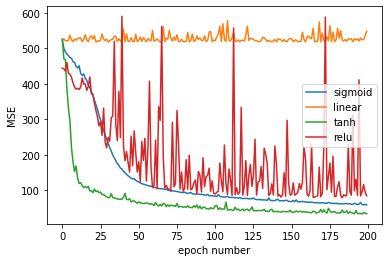

In [82]:
loss_sigmoid = nn_ss_sigmoid.mse_array
loss_linear = nn_ss_linear.mse_array
loss_tanh = nn_ss_tanh.mse_array
loss_relu = nn_ss_relu.mse_array

plt.plot(range(len(loss_sigmoid)), loss_sigmoid)
plt.plot(range(len(loss_linear)), loss_linear)
plt.plot(range(len(loss_tanh)), loss_tanh)
plt.plot(range(len(loss_relu)), loss_relu)
plt.legend(['sigmoid', 'linear', 'tanh', 'relu'])
plt.xlabel('epoch number')
plt.ylabel('MSE')
plt.show()

Najszybsza zbieżność jest dla `tanh`, potem `relu`, potem `sigmoid`, potem `linear`.

## Zbiór `multimodal_large`

In [83]:
ml_train = pd.read_csv('./mio1/regression/multimodal-large.csv', index_col=0)
ml_x_train = np.reshape(np.array(ml_train.x), (len(ml_train.x), 1))
ml_y_train = np.reshape(np.array(ml_train.y), (len(ml_train.x), 1))


ml_test = pd.read_csv('./mio1/regression/multimodal-large.csv', index_col=0)
ml_x_test = np.reshape(np.array(ml_test.x), (len(ml_test.x), 1))
ml_y_test = np.reshape(np.array(ml_test.y), (len(ml_test.x), 1))

FileNotFoundError: [Errno 2] No such file or directory: './mio1/regression/multimodal-large.csv'

In [ ]:
n_epochs = 20

In [ ]:
nn_ml_sigmoid = NN(input_shape=[len(ss_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['sigmoid', 'linear'])
nn_ml_sigmoid.fit(x_train=ml_x_train, y_train=ml_y_train, batch_size=2, n_epochs=n_epochs, x_test=ml_x_test, y_test=ml_y_test, learning_rate=0.0003)

In [ ]:
nn_ml_linear = NN(input_shape=[len(ml_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['linear', 'linear'])
nn_ml_linear.fit(x_train=ml_x_train, y_train=ml_y_train, batch_size=2, n_epochs=n_epochs, x_test=ml_x_test, y_test=ml_y_test, learning_rate=0.0003)

In [ ]:
nn_ml_tanh = NN(input_shape=[len(ml_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['tanh', 'linear'])
nn_ml_tanh.fit(x_train=ml_x_train, y_train=ml_y_train, batch_size=2, n_epochs=n_epochs, x_test=ml_x_test, y_test=ml_y_test, learning_rate=0.0003)

In [ ]:
nn_ml_relu = NN(input_shape=[len(ml_x_train), 1], output_size=1, layers_num=2, neurons_num=[100, 1], activations=['ReLU', 'linear'])
nn_ml_relu.fit(x_train=ml_x_train, y_train=ml_y_train, batch_size=2, n_epochs=n_epochs, x_test=ml_x_test, y_test=ml_y_test, learning_rate=0.0003)